In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

### Load data

In [7]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv',  delimiter=',')
valid = pd.read_csv('data/valid.csv',  delimiter=',')

In [8]:
train.drop(['Unnamed: 0', "film-url"], axis=1, inplace=True)
test.drop(['Unnamed: 0', "film-url"], axis=1, inplace=True)
valid.drop(['Unnamed: 0', "film-url"], axis=1, inplace=True)

### Preprocessing

We use TF-IDF to vectorize the text data with the french stop words. We also use the n-grams to keep the context of the words. We train with the vectorizer with the training data and then we use the same vectorizer to transform the test data

In [9]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
stop = list(fr_stop)
vectorizer = TfidfVectorizer(stop_words=stop)
vectorizer.fit(train['review'])
x_train = vectorizer.transform(train['review'])
x_test = vectorizer.transform(test['review'])
x_valid = vectorizer.transform(valid['review'])

/home/sambegou/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(


In [10]:
train.shape, test.shape, valid.shape

((160000, 2), (20000, 2), (20000, 2))

In [11]:
x_train.shape, x_test.shape, x_valid.shape

((160000, 152189), (20000, 152189), (20000, 152189))

### Train model

For the model, firstly we will use a simple logistic regression to see the performance. Then we will use a noter model like SVM or Random Forest to see if we can improve the performance.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
lr = LogisticRegression()
import seaborn as sns
lr.fit(x_train, train['polarity'])
pred = lr.predict(x_test)

/home/sambegou/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.92215
Recall:  0.9301501251042535
Precision:  0.909572841268223
F1 Score:  0.9197464048244935


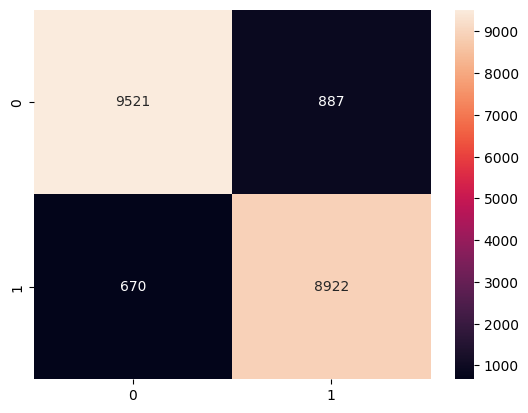

In [13]:
print("Accuracy: ", accuracy_score(test['polarity'], pred))
print("Recall: ", recall_score(test['polarity'], pred))
print("Precision: ", precision_score(test['polarity'], pred))
print("F1 Score: ", f1_score(test['polarity'], pred))
sns.heatmap(confusion_matrix(test['polarity'], pred), annot=True, fmt='g')
plt.show()

### Evaluate model
This previous step show us our model is good, the accuracy is 0.92. The Recall is little greather than the precision, it means that we have most false positive than false negative as we can see in the confusion matrix. The best representation of the performance is F1-score, it is the harmonic mean of precision and recall. The F1-score is 0.92, it is a good score.s So the metric we will use to evaluate our futur model is the F1-score

### Create a Pipeline

The pipeline allow us to do all the previous steps in one time.

In [14]:
from sklearn.pipeline import Pipeline
step = [('vectorizer', TfidfVectorizer(stop_words=stop)), ('lr', LogisticRegression())]
pipe = Pipeline(step)
pipe.fit(train['review'], train['polarity'])
pred = pipe.predict(test['review'])


/home/sambegou/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(
/home/sambegou/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.92235
Recall:  0.9302543786488741
Precision:  0.9098603038645865
F1 Score:  0.9199443270271663


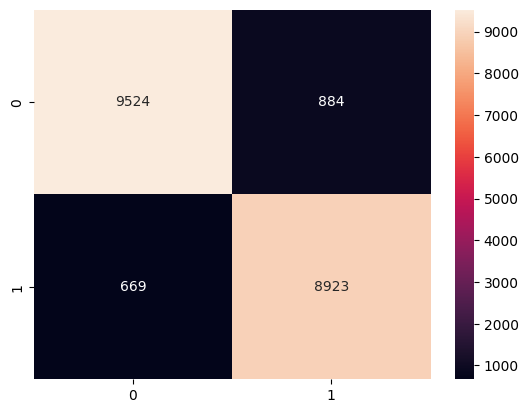

In [15]:
print("Accuracy: ", accuracy_score(test['polarity'], pred))
print("Recall: ", recall_score(test['polarity'], pred))
print("Precision: ", precision_score(test['polarity'], pred))
print("F1 Score: ", f1_score(test['polarity'], pred))
sns.heatmap(confusion_matrix(test['polarity'], pred), annot=True, fmt='g')
plt.show()

In [16]:
vectorizer = TfidfVectorizer(stop_words=stop)
vectorizer.fit(train['review'])

/home/sambegou/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(


TfidfVectorizer(stop_words=['ton', 'da', 'sien', 'leur', 'seront', 'mes',
                            'être', 'bas', 'désormais', 'compris', 'ceux-là',
                            'celle-là', 'miens', 'dont', 'vas', 'douze', 'na',
                            'sa', 'quoi', 'antérieures', 'nos', 'moins',
                            'specifique', 'vont', "d'", 'avaient', 'autre',
                            'avec', 'ès', 'meme', ...])

## Testing different models of logistic regression
In the previous step, we have used a simple logistic regression. In this step, we will test different models of logistic regression to see if we can improve the performance. We will test the following models:

- Logistic regression with L1 regularization with different values of C
- Logistic regression with L2 regularization with different values of C

The Results of best model is returned by the function `tune_model()`.


In [80]:
def tune_model(X_train, y_train, X_test, y_test):
    results = pd.DataFrame(columns=['model', 'C', 'f1_score'])

    parameters = {'C': [ 0.01, 10, 100, 1000], 
                  'penalty': ['l1', 'l2']}

    best_score = 0
    best_params = None


    for C in parameters['C']:
        for penalty in parameters['penalty']:
           
            model = LogisticRegression(C=C, penalty=penalty, solver='liblinear')

            model.fit(X_train, y_train)

            
            predictions = model.predict(X_test)
            score = f1_score(y_test, predictions)
            data  = pd.DataFrame(data = {'model': penalty, 'C':  C, 'f1_score': score}, index=[0])
            results = pd.concat( [results, data], ignore_index=True)
            
            if score > best_score:
                best_score = score
                best_params = {'C': C, 'penalty': penalty}

    # show best parameters
    print("Best parameters: ", best_params)

    # return best model
    return LogisticRegression(**best_params), results

In [71]:
X_train = vectorizer.transform(train['review'])
y_train = train['polarity']
X_test = vectorizer.transform(test['review'])
y_test = test['polarity']

In [81]:
best_log,resultat = tune_model(X_train, y_train, X_test, y_test)

/tmp/ipykernel_16374/373189690.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat( [results, data], ignore_index=True)


Best parameters:  {'C': 10, 'penalty': 'l2'}


In [82]:
resultat

,model,C,f1_score
0,l1,0.01,0.774806
1,l2,0.01,0.881872
2,l1,10.00,0.907742
3,l2,10.00,0.917271
4,l1,100.00,0.872005
5,l2,100.00,0.899046
6,l1,1000.00,0.841618
7,l2,1000.00,0.876603


In [74]:
print(f"the best model : {best_log}")

the best model : LogisticRegression(C=10)


As we can see in the table below, the best model is the logistic regression with L2 regularization with C=10

## Testing different other models
In this step, we will test the svm and the MLP. And we will compare the performance of these models with the logistic regression.

In [84]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def test_model(x_train, y_train, x_test, y_test):
    results = pd.DataFrame(columns=['model', 'params', 'f1_score'])
    algorithms = {
        'SVC': {
            'model': SVC,
            'params': {'C': [0.1, 1, 10]}
        },
        'MLP': {
            'model': MLPClassifier,
            'params': {'hidden_layer_sizes': [(10,), (50,), (100,)]}
        }
    }

    best_score = 0
    best_algo = None
    best_params = None


    for algo_name, algo in algorithms.items():
       
        for param_name, param_values in algo['params'].items():
            for param_value in param_values:
               
                model = algo['model'](**{param_name: param_value})
  
                model.fit(x_train, y_train)

               
                predictions = model.predict(x_test)
                score = f1_score(y_test, predictions)
                data  = pd.DataFrame({'model': str(model), 'params': param_values, 'f1_score': score}, index=[0])
                results = pd.concat([results, data], ignore_index=True)
                if score > best_score:
                    best_score = score
                    best_algo = algo_name
                    best_params = {param_name: param_value}

    print("Best algorithm: ", best_algo)
    print("Best parameters: ", best_params)

    
    return algorithms[best_algo]['model'](**best_params), results

In [85]:
# test_model(X_train, y_train, X_test, y_test)